In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.chdir('..')

import pickle

import torch
import datasets
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.modeling_outputs import CausalLMOutputWithPast

from tqdm import tqdm

from model import MemoryCell

In [3]:
import pandas as pd
# df = pd.DataFrame({'text': texts})
# df.to_csv('pg19_valid_1k_chunks.csv')
texts_df = pd.read_csv('./data/pg19_valid_1k_chunks.csv', index_col=0)
texts_df.head()

,text
0,"'Let us stay here,' she exclaimed. 'The one ro..."
1,These lobsters don't realize that Jonesy's fas...
2,It certainly was not relief that he felt on di...
3,Down to 1765 the duty imposed was only one pen...
4,"And what was, perhaps, more extraordinary, tho..."


In [5]:
models = ['EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b',
          'EleutherAI/pythia-2.8b',
          'allenai/OLMo-1B-0724-hf', 'facebook/opt-1.3b',
          'princeton-nlp/Sheared-LLaMA-1.3B',
          'meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B']
max_lengths = [64, 96, 128, 192, 256, 384, 512, 768, 1024, 1280, 1568, 2048, 2560, 3072]
N_mem_tokens = 1

data = []
from pathlib import Path
for model_name in tqdm(models):
    for max_length in max_lengths:
        load_path = Path(f'./runs/{model_name}/mem_{N_mem_tokens}_len_{max_length}.pkl')
        try:
            d = pickle.load(open(load_path, 'rb'))
        except:
            continue
        for el in d:
            data += [{
                'model_name': model_name,
                'max_length': el['max_length'],
                'n_mem_tokens': el['n_mem_tokens'],
                'original_loss': el['original_loss'],
                'best_loss': el['best_loss'],
                'best_accuracy': el['best_accuracy'],
            }]
all_models_df = pd.DataFrame(data)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


In [6]:
#model_name = 'EleutherAI/pythia-160m'
# model_name = 'princeton-nlp/Sheared-LLaMA-1.3B'
model_name = 'meta-llama/Meta-Llama-3.1-8B'
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_lengths = [64, 96, 128, 192, 256, 384, 512, 768, 1024, 1280, 1568, 2048, 2560, 3072]
N_mem_tokens = 1

from nltk import sent_tokenize
text_sample = texts_df['text'][0]
sentences = sent_tokenize(text_sample)
prefix_text = ' '.join(sentences[:len(sentences)//2])
suffix_text = ' '.join(sentences[len(sentences)//2:])

inp = tokenizer(suffix_text, max_length=16, truncation=True)
inp

{'input_ids': [128000, 16366, 6548, 2322, 1884, 315, 16852, 817, 11, 889, 574, 100115, 389, 279, 1023, 3185], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

/tmp/ipykernel_1544960/1424908463.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(polynomial, x_data, y_data)
/tmp/ipykernel_1544960/1424908463.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(df['max_length'].unique()))


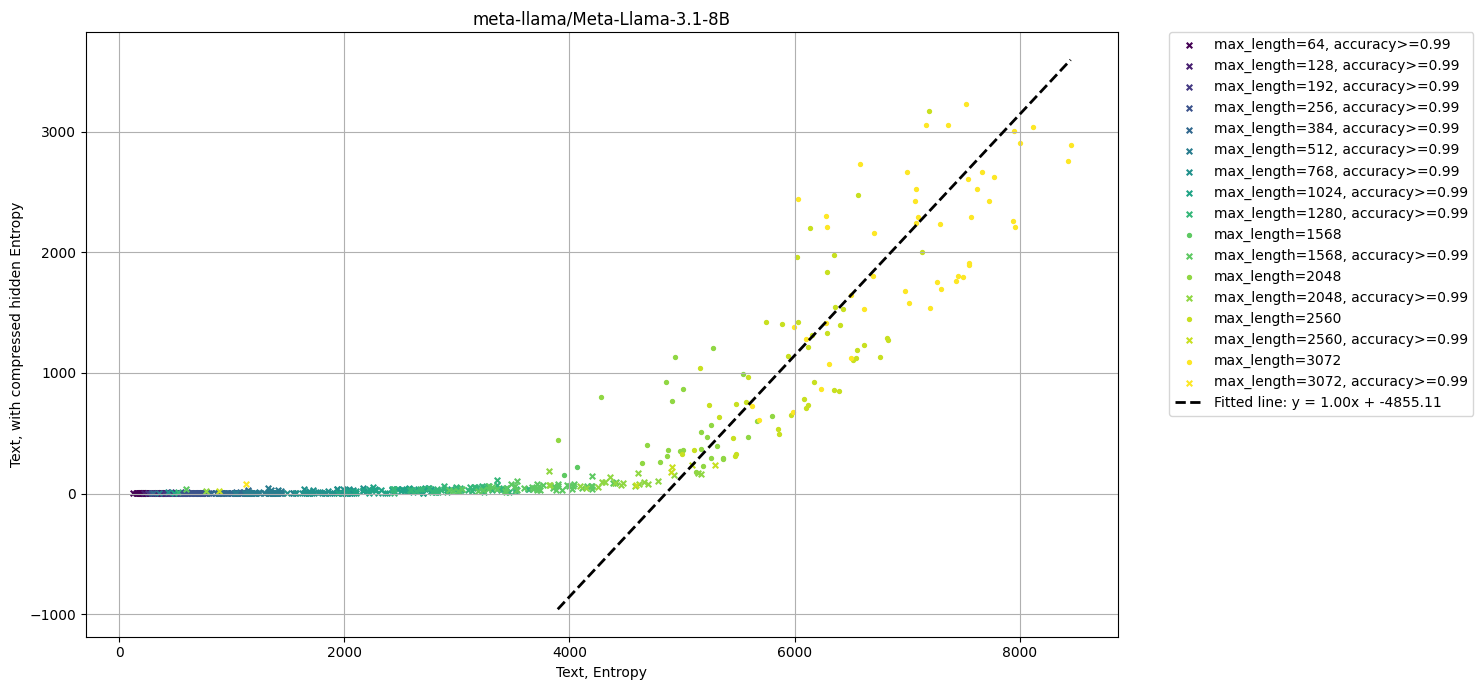

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd

import seaborn as sns
sns.reset_defaults()

# Assume `df` is a pandas DataFrame with columns: max_length, n_mem_tokens, original_loss, best_loss, best_accuracy, length

# Define a polynomial function for fitting (let's try a quadratic fit)
def polynomial(x, a, b):
    return 1 * x + b

s = 8
acc_thr = 0.99

df = all_models_df[all_models_df['model_name'] == model_name]
df

# Split data based on best_accuracy threshold
d_below_thr = df[df['best_accuracy'] < acc_thr]
d_above_thr = df[df['best_accuracy'] >= acc_thr]

# Extract data for fitting
x_data = d_below_thr['original_loss'] * d_below_thr['max_length']
y_data = d_below_thr['best_loss'] * d_below_thr['max_length']

# Use curve_fit to fit the polynomial function to the data
params, _ = curve_fit(polynomial, x_data, y_data)
a, b = params

# Generate values for the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 500)
y_fit = polynomial(x_fit, *params)

# Define a colormap to assign consistent colors to each unique max_length
colors = plt.cm.get_cmap('viridis', len(df['max_length'].unique()))
color_map = {max_length: colors(i) for i, max_length in enumerate(df['max_length'].unique())}

plt.figure(figsize=(15, 7))

# Plot data points, grouped by max_length
for max_length in df['max_length'].unique():
    subset_below = d_below_thr[d_below_thr['max_length'] == max_length]
    subset_above = d_above_thr[d_above_thr['max_length'] == max_length]

    # Plot points below the accuracy threshold
    if len(subset_below) > 0:
        plt.scatter(
            subset_below['original_loss'] * max_length, 
            subset_below['best_loss'] * max_length,
            label=f'max_length={max_length}',
            s=s,
            color=color_map[max_length]
        )

    # Plot points above the accuracy threshold
    if len(subset_above) > 0:
        plt.scatter(
            subset_above['original_loss'] * max_length, 
            subset_above['best_loss'] * max_length,
            color=color_map[max_length],  # Use the same color as for the points below the threshold
            marker='x', 
            s=s * 2,
            label=f'max_length={max_length}, accuracy>={acc_thr}'
        )

# Plot the fitted curve with formula in the legend
formula_label = f'Fitted line: y = {a:.2f}x + {b:.2f}'
plt.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=formula_label)

# Find the value of best_loss corresponding to the accuracy threshold
best_loss_thr = (d_above_thr['best_loss'] * d_above_thr['max_length']).max()

# Add a horizontal line for the best_loss threshold
# plt.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=2, label=f'loss threshold for accuracy >= {acc_thr}')

# Labels, legend, and grid
plt.xlabel('Text, Entropy')
plt.ylabel('Text, with compressed hidden Entropy')

# Move the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title(f'{model_name}')

plt.grid()
plt.tight_layout()  # Adjust layout to accommodate the legend outside
plt.show()


/tmp/ipykernel_1544960/253414298.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))
/tmp/ipykernel_1544960/253414298.py:48: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(polynomial, x_data, y_data)
/tmp/ipykernel_1544960/253414298.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(df['max_length'].unique()))


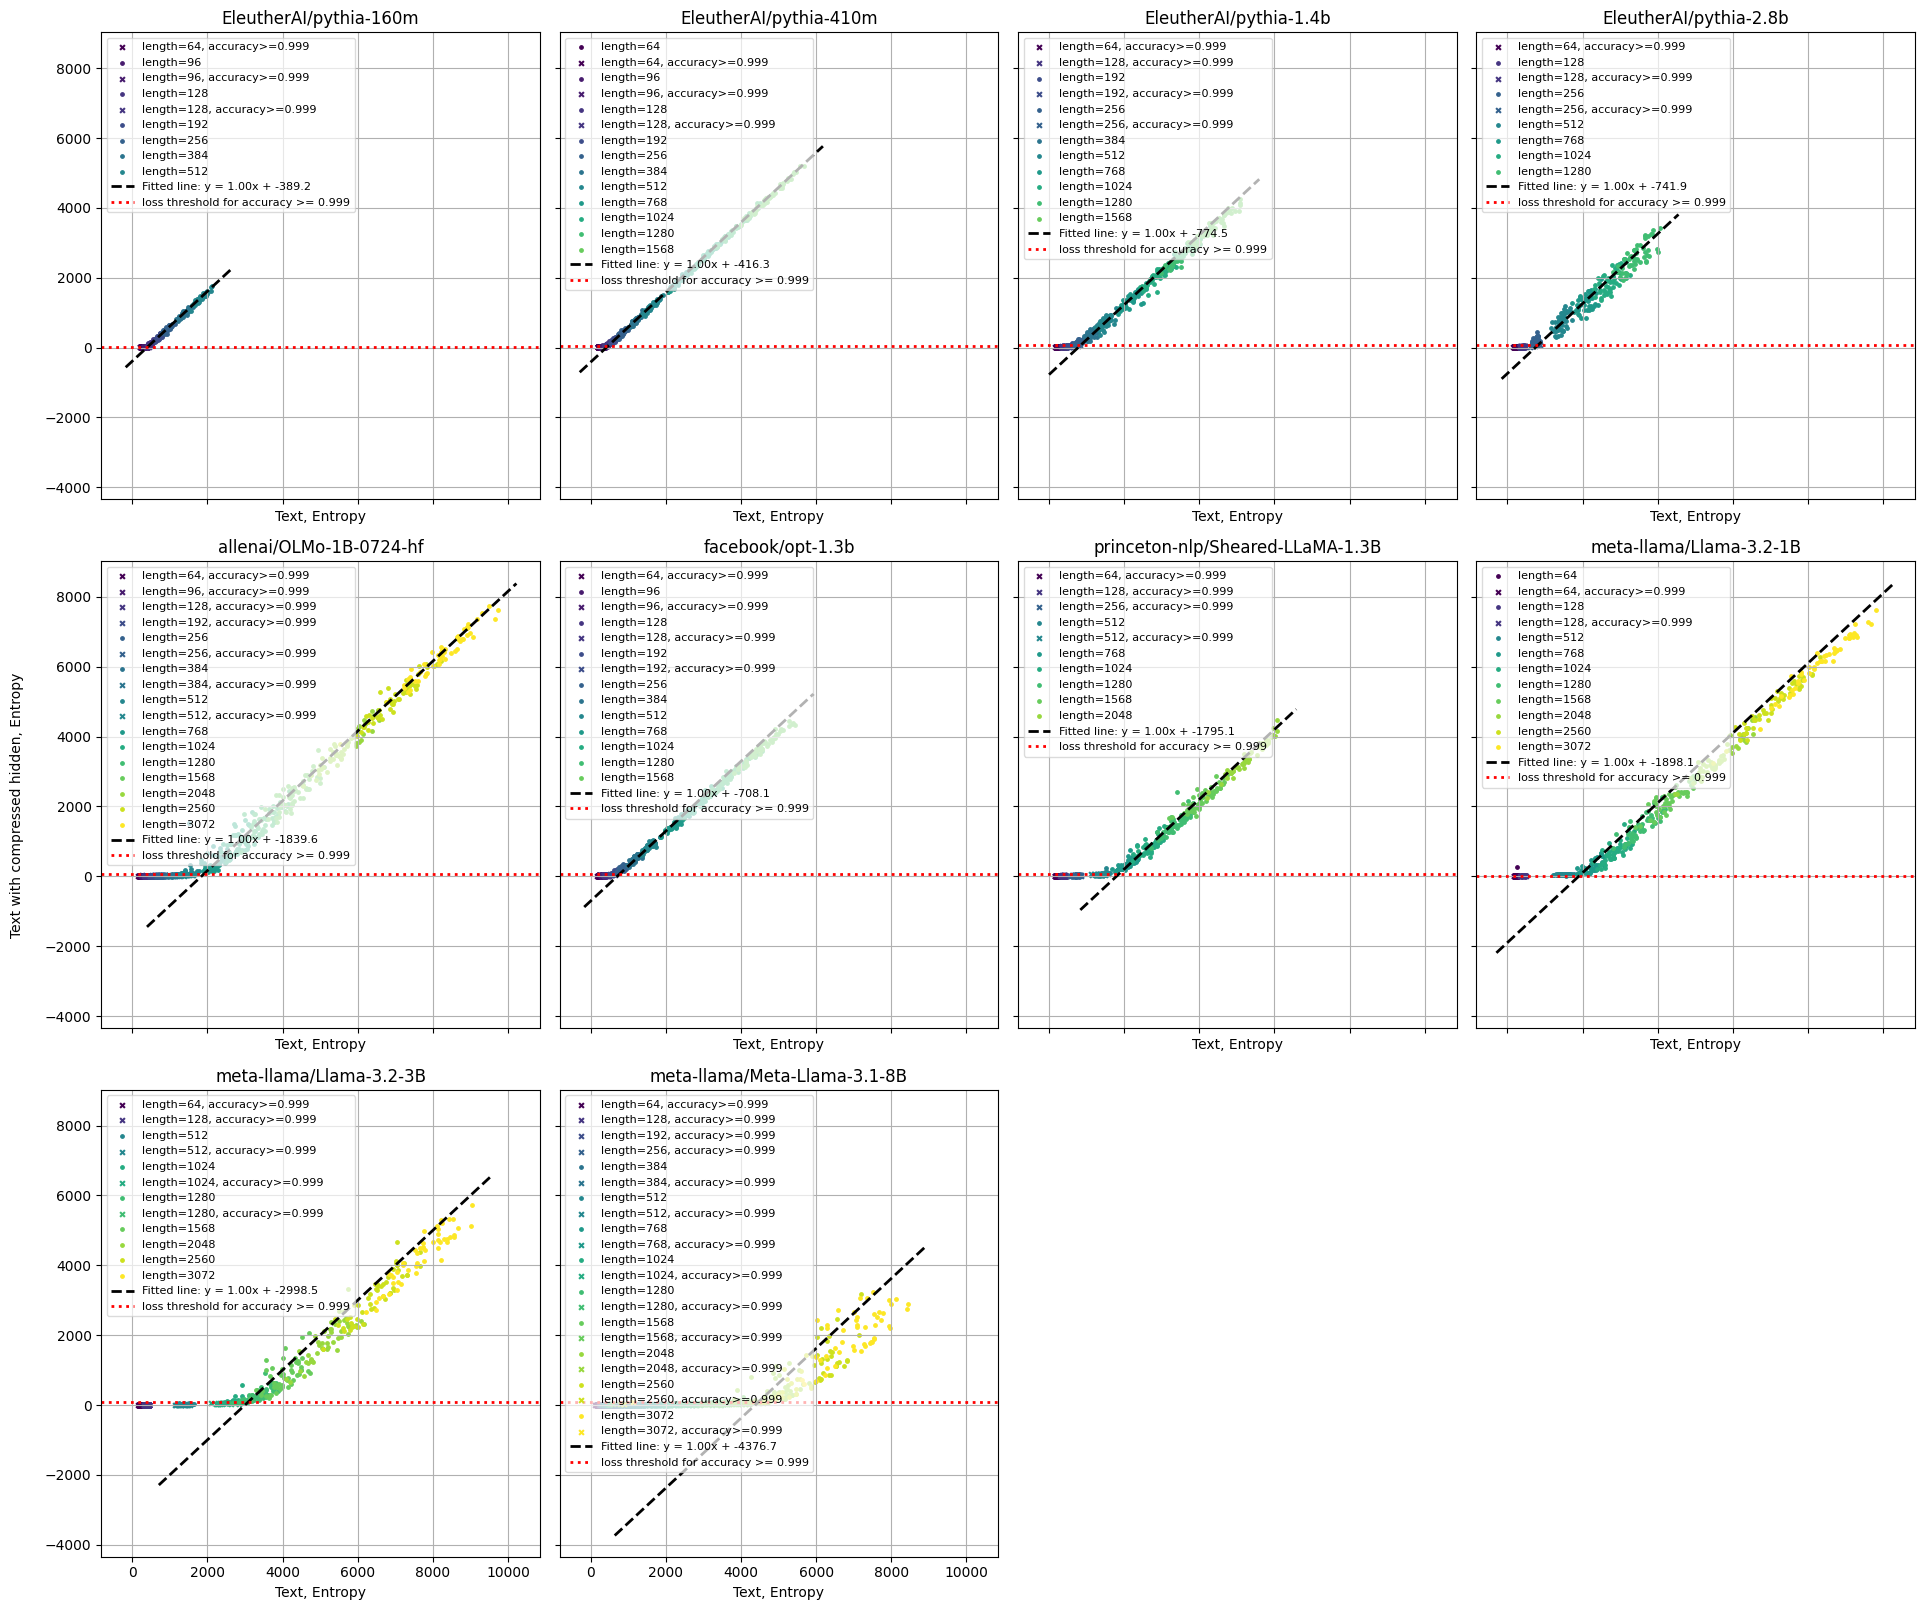

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
from transformers import AutoTokenizer

import seaborn as sns
sns.reset_defaults()

# List of models
models = ['EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b',
          'EleutherAI/pythia-2.8b',
          'allenai/OLMo-1B-0724-hf', 'facebook/opt-1.3b',
          'princeton-nlp/Sheared-LLaMA-1.3B',
          'meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B']
max_lengths = [64, 96, 128, 192, 256, 384, 512, 768, 1024, 1280, 1568, 2048, 2560, 3072]
N_mem_tokens = 1

# Create subplots for each model
n_columns = 4
n_rows = (len(models) + n_columns - 1) // n_columns
fig, axes = plt.subplots(n_rows, n_columns, figsize=(20, 6 * n_rows),sharey=True,sharex=True)

s = 6
acc_thr = 0.999

# Define a global color map for max_lengths
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

data = []
for idx, model_name in enumerate(models):

    df = all_models_df[all_models_df['model_name'] == model_name]
    if len(df) == 0:
        print(f'skipping {model_name}')
        continue

    # Split data based on best_accuracy threshold
    d_below_thr = df[df['best_accuracy'] < acc_thr]
    d_above_thr = df[df['best_accuracy'] >= acc_thr]

    # Extract data for fitting
    x_data = d_below_thr['original_loss'] * d_below_thr['max_length']
    y_data = d_below_thr['best_loss'] * d_below_thr['max_length']

    # Use curve_fit to fit the polynomial function to the data
    params, _ = curve_fit(polynomial, x_data, y_data)
    a, b = params

    # Generate values for the fitted curve
    x_fit = np.linspace(min(x_data) - 500, max(x_data) + 500, 500)
    y_fit = polynomial(x_fit, *params)

    # Define a colormap to assign consistent colors to each unique max_length
    colors = plt.cm.get_cmap('viridis', len(df['max_length'].unique()))
    color_map = {max_length: colors(i) for i, max_length in enumerate(df['max_length'].unique())}

    ax = axes.flat[idx]

    # Plot data points, grouped by max_length
    for max_length in df['max_length'].unique():
        subset_below = d_below_thr[d_below_thr['max_length'] == max_length]
        subset_above = d_above_thr[d_above_thr['max_length'] == max_length]

        # Plot points below the accuracy threshold
        if len(subset_below) > 0:
            ax.scatter(
                subset_below['original_loss'] * max_length, 
                subset_below['best_loss'] * max_length,
                label=f'length={max_length}',
                s=s,
                color=global_color_map[max_length]
            )

        # Plot points above the accuracy threshold
        if len(subset_above) > 0:
            ax.scatter(
                subset_above['original_loss'] * max_length, 
                subset_above['best_loss'] * max_length,
                color=global_color_map[max_length],  # Use the same color as for the points below the threshold
                marker='x', 
                s=s * 2,
                label=f'length={max_length}, accuracy>={acc_thr}'
            )

    # Plot the fitted curve with formula in the legend
    formula_label = f'Fitted line: y = {a:.2f}x + {b:.1f}'
    ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=formula_label)

    # Find the value of best_loss corresponding to the accuracy threshold
    best_loss_thr = (d_above_thr['best_loss'] * d_above_thr['max_length']).max()

    # Add a horizontal line for the best_loss threshold
    ax.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=2, label=f'loss threshold for accuracy >= {acc_thr}')

    # Labels, legend, and grid for each subplot
    ax.set_xlabel('Text, Entropy')
    ax.set_title(f'{model_name}')
    ax.grid()

    # Move the legend outside of the plot for each subplot
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.legend(loc='upper left', fontsize=8, frameon=True, fancybox=True, framealpha=0.7)
    


# Set common ylabel for all subplots
# axes[0,0].set_ylabel('Text loss with compressed hidden * length')

# Remove any empty subplots if there are fewer models than subplots
for idx in range(len(models), n_rows * n_columns):
    fig.delaxes(axes.flat[idx])

# Set common ylabel for all subplots
fig.text(0.04, 0.5, 'Text with compressed hidden, Entropy', va='center', rotation='vertical', fontsize=10)


plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Adjust layout to accommodate legends and labels properly
plt.show()


/tmp/ipykernel_1544960/1310465077.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))
/tmp/ipykernel_1544960/1310465077.py:44: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(polynomial, x_data, y_data)
/tmp/ipykernel_1544960/1310465077.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(df['max_length'].unique()))


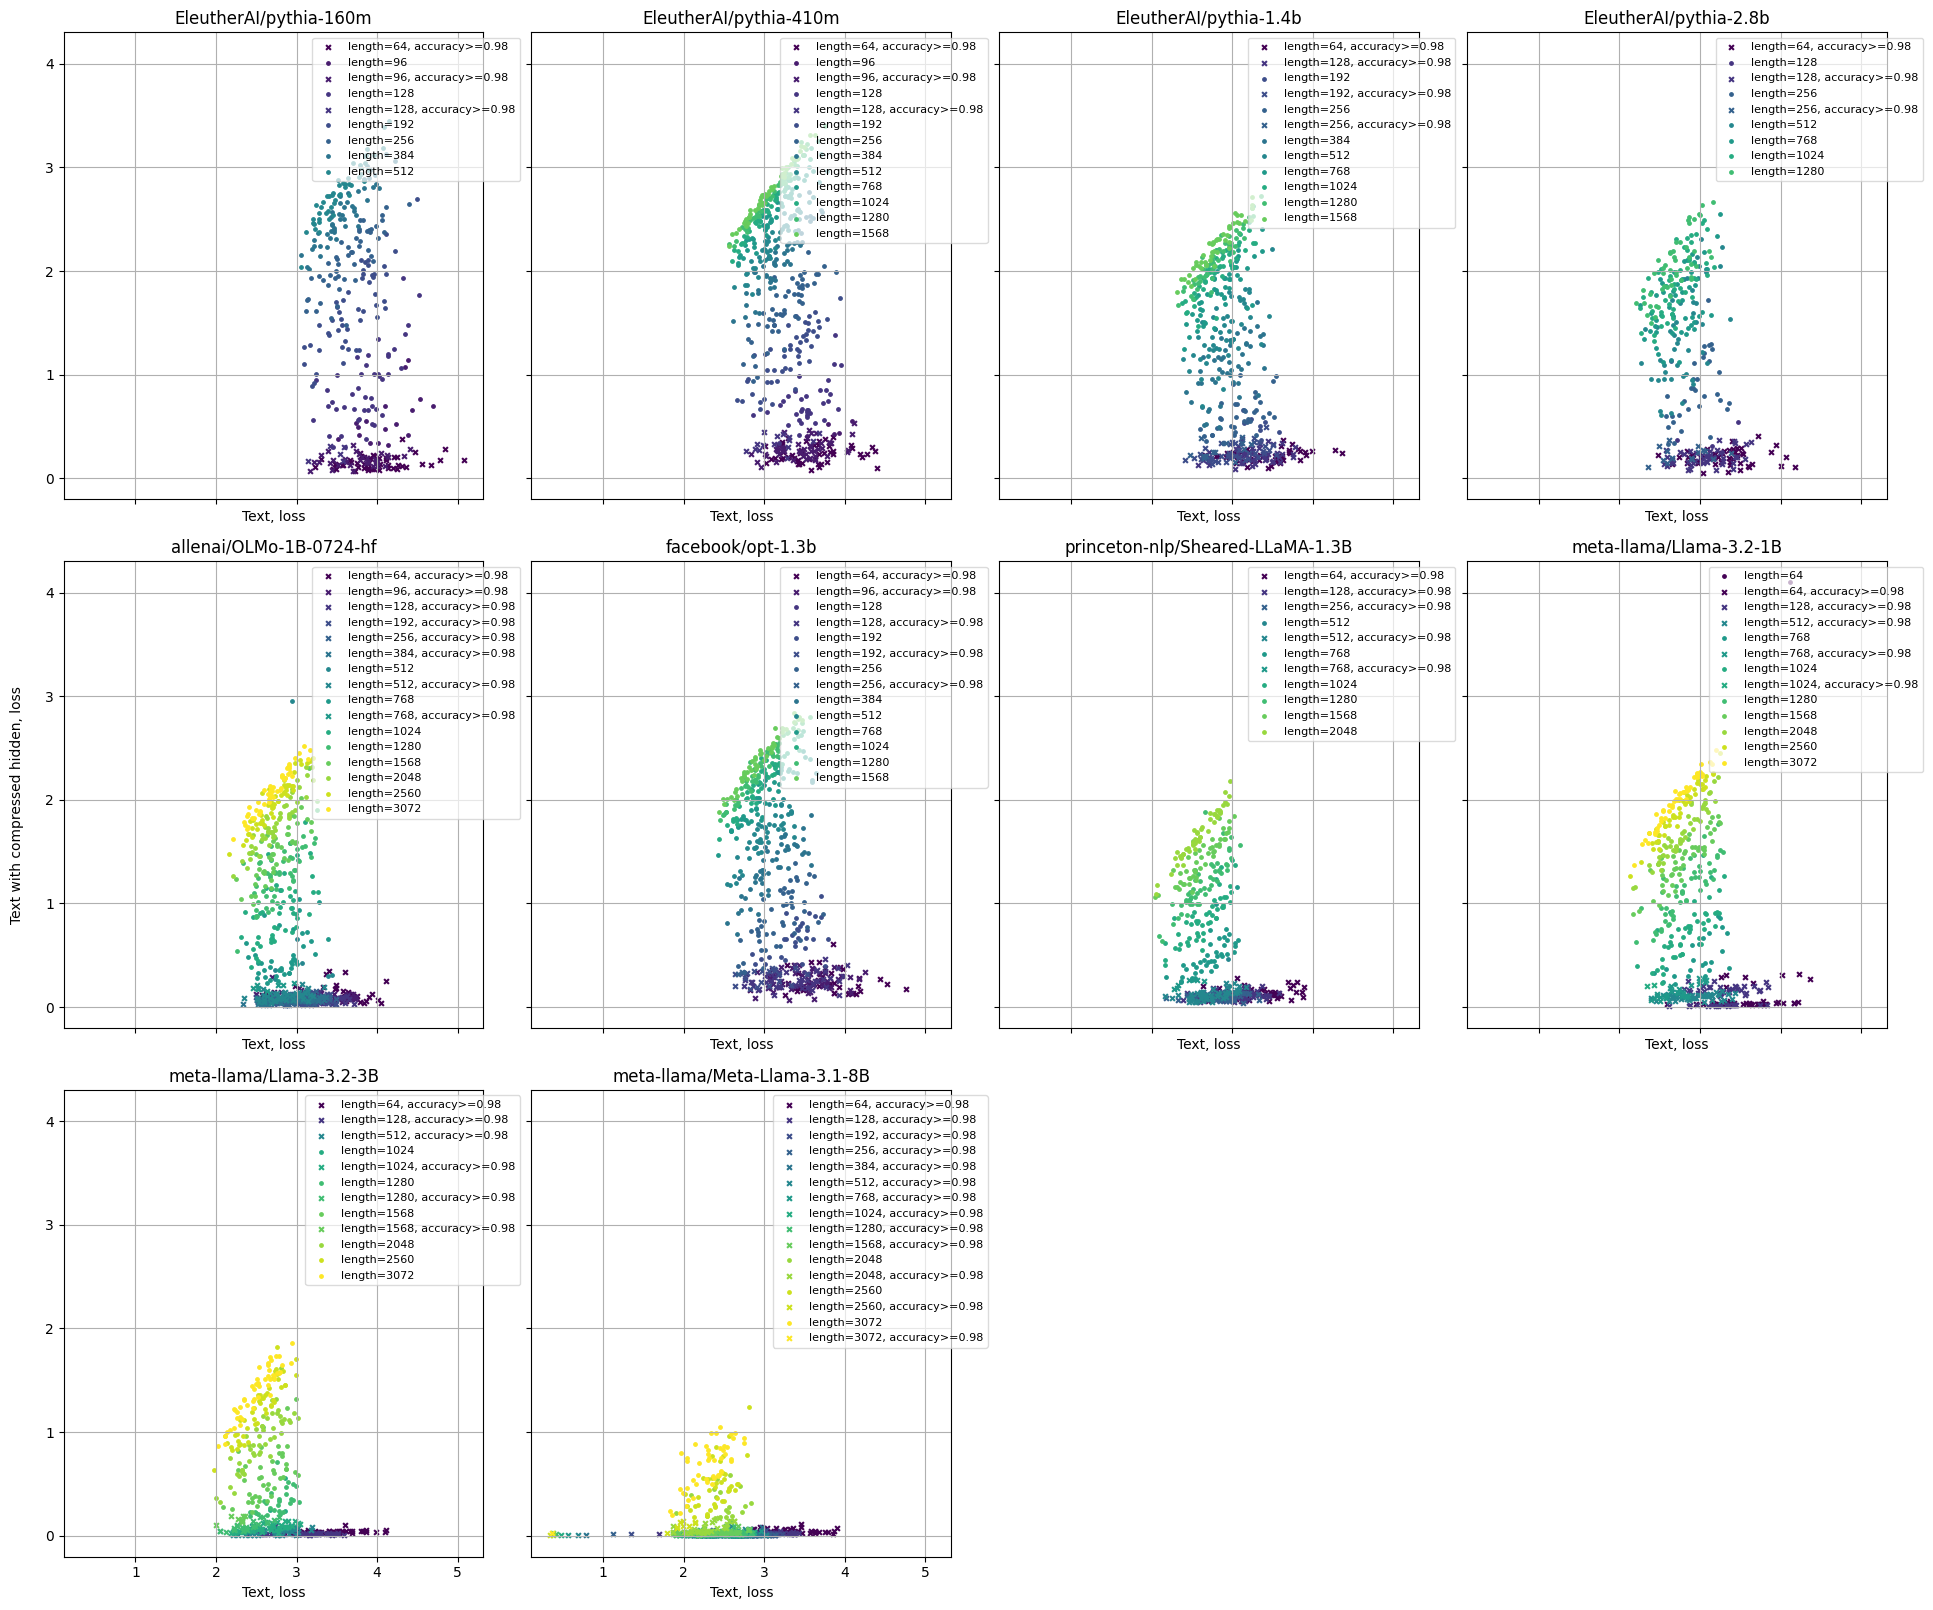

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
from transformers import AutoTokenizer

# List of models
# models = ['EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b',
#            'EleutherAI/pythia-2.8b',
#           'princeton-nlp/Sheared-LLaMA-1.3B',
#           'meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B']
max_lengths = [64, 96, 128, 192, 256, 384, 512, 768, 1024, 1280, 1568, 2048, 2560, 3072]
N_mem_tokens = 1

# Create subplots for each model
n_columns = 4
n_rows = (len(models) + n_columns - 1) // n_columns
fig, axes = plt.subplots(n_rows, n_columns, figsize=(20, 6 * n_rows),sharey=True,sharex=True)

s = 6
acc_thr = 0.98

# Define a global color map for max_lengths
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

data = []
for idx, model_name in enumerate(models):

    df = all_models_df[all_models_df['model_name'] == model_name]
    if len(df) == 0:
        print(f'skipping {model_name}')
        continue

    # Split data based on best_accuracy threshold
    d_below_thr = df[df['best_accuracy'] < acc_thr]
    d_above_thr = df[df['best_accuracy'] >= acc_thr]

    # Extract data for fitting
    x_data = d_below_thr['original_loss'] * d_below_thr['max_length']
    y_data = d_below_thr['best_loss'] * d_below_thr['max_length']

    # Use curve_fit to fit the polynomial function to the data
    params, _ = curve_fit(polynomial, x_data, y_data)
    a, b = params

    # Generate values for the fitted curve
    x_fit = np.linspace(min(x_data) - 500, max(x_data) + 500, 500)
    y_fit = polynomial(x_fit, *params)

    # Define a colormap to assign consistent colors to each unique max_length
    colors = plt.cm.get_cmap('viridis', len(df['max_length'].unique()))
    color_map = {max_length: colors(i) for i, max_length in enumerate(df['max_length'].unique())}

    ax = axes.flat[idx]

    # Plot data points, grouped by max_length
    for max_length in df['max_length'].unique():
        subset_below = d_below_thr[d_below_thr['max_length'] == max_length]
        subset_above = d_above_thr[d_above_thr['max_length'] == max_length]

        # Plot points below the accuracy threshold
        if len(subset_below) > 0:
            ax.scatter(
                subset_below['original_loss'], 
                subset_below['best_loss'],
                label=f'length={max_length}',
                s=s,
                color=global_color_map[max_length]
            )

        # Plot points above the accuracy threshold
        if len(subset_above) > 0:
            ax.scatter(
                subset_above['original_loss'], 
                subset_above['best_loss'],
                color=global_color_map[max_length],  # Use the same color as for the points below the threshold
                marker='x', 
                s=s * 2,
                label=f'length={max_length}, accuracy>={acc_thr}'
            )

    # Plot the fitted curve with formula in the legend
    formula_label = f'Fitted line: y = {a:.3f}x + {b:.1f}'
    # ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=formula_label)

    # Find the value of best_loss corresponding to the accuracy threshold
    best_loss_thr = (d_above_thr['best_loss'] * d_above_thr['max_length']).max()

    # Add a horizontal line for the best_loss threshold
    # ax.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=2, label=f'loss threshold for accuracy >= {acc_thr}')

    # Labels, legend, and grid for each subplot
    ax.set_xlabel('Text, loss')
    ax.set_title(f'{model_name}')
    ax.grid()

    # Move the legend outside of the plot for each subplot
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=8, frameon=True, fancybox=True, framealpha=0.7)
    


# Set common ylabel for all subplots
# axes[0,0].set_ylabel('Text loss with compressed hidden * length')

# Remove any empty subplots if there are fewer models than subplots
for idx in range(len(models), n_rows * n_columns):
    fig.delaxes(axes.flat[idx])

# Set common ylabel for all subplots
fig.text(0.04, 0.5, 'Text with compressed hidden, loss', va='center', rotation='vertical', fontsize=10)


plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Adjust layout to accommodate legends and labels properly
plt.show()


In [16]:
all_models_df['loss_diff']  = (all_models_df['original_loss'] - all_models_df['best_loss']) * all_models_df['max_length']
all_models_df['original_CE']  = all_models_df['original_loss'] * all_models_df['max_length']

In [17]:
all_models_df

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,loss_diff,original_CE
0,EleutherAI/pythia-160m,64,1,3.228437,0.107728,1.000000,199.725412,206.619980
1,EleutherAI/pythia-160m,64,1,3.842608,0.100900,1.000000,239.469337,245.926910
2,EleutherAI/pythia-160m,64,1,3.451642,0.090220,1.000000,215.130980,220.905090
3,EleutherAI/pythia-160m,64,1,4.202715,0.101181,1.000000,262.498209,268.973785
4,EleutherAI/pythia-160m,64,1,3.900694,0.188459,1.000000,237.583039,249.644394
...,...,...,...,...,...,...,...,...
5045,meta-llama/Meta-Llama-3.1-8B,3072,1,2.751091,0.940136,0.805601,5563.253723,8451.350830
5046,meta-llama/Meta-Llama-3.1-8B,3072,1,2.439051,0.584458,0.882774,5697.308350,7492.764404
5047,meta-llama/Meta-Llama-3.1-8B,3072,1,2.304736,0.731364,0.846955,4833.399719,7080.149414
5048,meta-llama/Meta-Llama-3.1-8B,3072,1,1.987353,0.416031,0.922826,4827.099701,6105.148315


In [18]:
all_models_df.groupby('model_name').mean()['original_loss']

model_name
EleutherAI/pythia-1.4b              2.988536
EleutherAI/pythia-160m              3.738071
EleutherAI/pythia-2.8b              2.881056
EleutherAI/pythia-410m              3.246289
allenai/OLMo-1B-0724-hf             2.928677
facebook/opt-1.3b                   3.176934
meta-llama/Llama-3.2-1B             2.923181
meta-llama/Llama-3.2-3B             2.719957
meta-llama/Meta-Llama-3.1-8B        2.519377
princeton-nlp/Sheared-LLaMA-1.3B    2.788559
Name: original_loss, dtype: float64

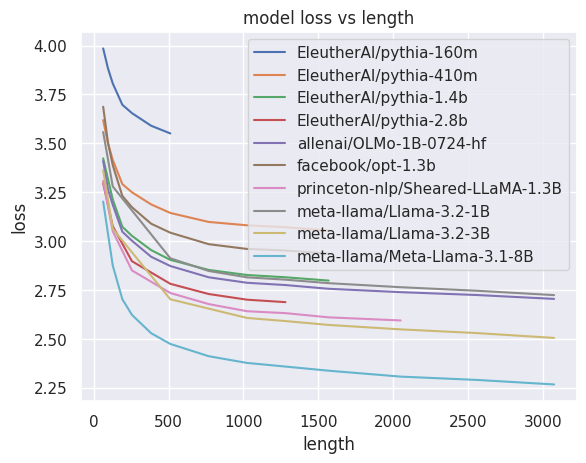

In [19]:
import seaborn as sns
pd.set_option('display.max_rows', 200)
sns.set_theme()
models_by_len_df = all_models_df.groupby(['model_name', 'max_length'], as_index=False).mean()
for model_name in models:
    model_df = models_by_len_df[models_by_len_df['model_name']==model_name]
    plt.plot(model_df['max_length'], model_df['original_loss'], label=model_name)
plt.title('model loss vs length')
plt.xlabel('length')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
models_by_len_df[models_by_len_df['max_length'] == 512].sort_values('original_CE', ascending=False)

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,loss_diff,original_CE
16,EleutherAI/pythia-160m,512,1.0,3.550560,2.769871,0.478121,399.712678,1817.886501
30,EleutherAI/pythia-410m,512,1.0,3.143882,2.307979,0.540978,427.982770,1609.667834
55,facebook/opt-1.3b,512,1.0,3.042876,1.685677,0.661722,694.885930,1557.952532
62,meta-llama/Llama-3.2-1B,512,1.0,2.912045,0.100949,0.997847,1439.281161,1490.967146
5,EleutherAI/pythia-1.4b,512,1.0,2.903877,1.415691,0.722074,761.951082,1486.784961
41,allenai/OLMo-1B-0724-hf,512,1.0,2.872495,0.200012,0.979139,1368.311272,1470.717417
20,EleutherAI/pythia-2.8b,512,1.0,2.781524,1.399072,0.718200,707.815400,1424.140183
95,princeton-nlp/Sheared-LLaMA-1.3B,512,1.0,2.734495,0.125752,0.997378,1335.676461,1400.061311
72,meta-llama/Llama-3.2-3B,512,1.0,2.702343,0.050574,0.998434,1357.705907,1383.599851
84,meta-llama/Meta-Llama-3.1-8B,512,1.0,2.473942,0.011086,0.999883,1260.982045,1266.658187


In [36]:
all_models_df['original_loss_mean'] = all_models_df.groupby('model_name')['original_loss'].transform('mean')

In [37]:
all_models_df['original_loss_mean_by_len'] = all_models_df.apply(lambda x: models_by_len_df[(models_by_len_df['model_name'] == x['model_name']) & (models_by_len_df['max_length'] == x['max_length'])]['original_loss'].item(), axis=1)


In [38]:
all_models_df

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,loss_diff,original_loss_mean,original_loss_mean_by_len
0,EleutherAI/pythia-160m,64,1,3.228437,0.107728,1.000000,199.725412,3.738071,3.985207
1,EleutherAI/pythia-160m,64,1,3.842608,0.100900,1.000000,239.469337,3.738071,3.985207
2,EleutherAI/pythia-160m,64,1,3.451642,0.090220,1.000000,215.130980,3.738071,3.985207
3,EleutherAI/pythia-160m,64,1,4.202715,0.101181,1.000000,262.498209,3.738071,3.985207
4,EleutherAI/pythia-160m,64,1,3.900694,0.188459,1.000000,237.583039,3.738071,3.985207
...,...,...,...,...,...,...,...,...,...
4145,meta-llama/Meta-Llama-3.1-8B,3072,1,2.751091,0.940136,0.805601,5563.253723,2.538504,2.266800
4146,meta-llama/Meta-Llama-3.1-8B,3072,1,2.439051,0.584458,0.882774,5697.308350,2.538504,2.266800
4147,meta-llama/Meta-Llama-3.1-8B,3072,1,2.304736,0.731364,0.846955,4833.399719,2.538504,2.266800
4148,meta-llama/Meta-Llama-3.1-8B,3072,1,1.987353,0.416031,0.922826,4827.099701,2.538504,2.266800


In [94]:
all_models_df['XXX'] = all_models_df['loss_diff'] / (all_models_df['original_loss'])
all_models_df

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,loss_diff,original_loss_mean,original_loss_mean_by_len,XXX
0,EleutherAI/pythia-160m,64,1,3.228437,0.107728,1.000000,199.725412,3.738071,3.985207,61.864426
1,EleutherAI/pythia-160m,64,1,3.842608,0.100900,1.000000,239.469337,3.738071,3.985207,62.319481
2,EleutherAI/pythia-160m,64,1,3.451642,0.090220,1.000000,215.130980,3.738071,3.985207,62.327141
3,EleutherAI/pythia-160m,64,1,4.202715,0.101181,1.000000,262.498209,3.738071,3.985207,62.459192
4,EleutherAI/pythia-160m,64,1,3.900694,0.188459,1.000000,237.583039,3.738071,3.985207,60.907895
...,...,...,...,...,...,...,...,...,...,...
4145,meta-llama/Meta-Llama-3.1-8B,3072,1,2.751091,0.940136,0.805601,5563.253723,2.538504,2.266800,2022.199265
4146,meta-llama/Meta-Llama-3.1-8B,3072,1,2.439051,0.584458,0.882774,5697.308350,2.538504,2.266800,2335.871022
4147,meta-llama/Meta-Llama-3.1-8B,3072,1,2.304736,0.731364,0.846955,4833.399719,2.538504,2.266800,2097.159688
4148,meta-llama/Meta-Llama-3.1-8B,3072,1,1.987353,0.416031,0.922826,4827.099701,2.538504,2.266800,2428.909097


In [87]:
# ok, we found compression value for a single model (loss_diff) that is stable across all lengths.

# but how to generalize it across all models? use some model characteristic for it?

In [88]:
import seaborn as sns

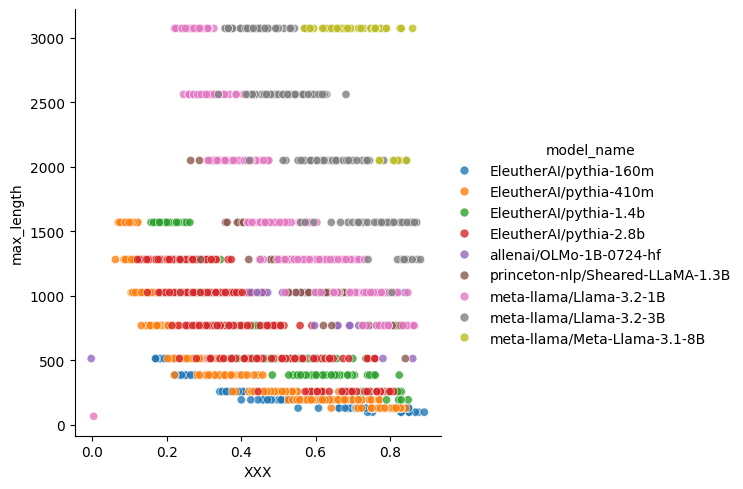

In [89]:
sns.relplot(data=all_models_df[all_models_df['best_accuracy'] < 0.95],
            x='XXX', y='max_length', hue='model_name', alpha=0.8)
plt.show()

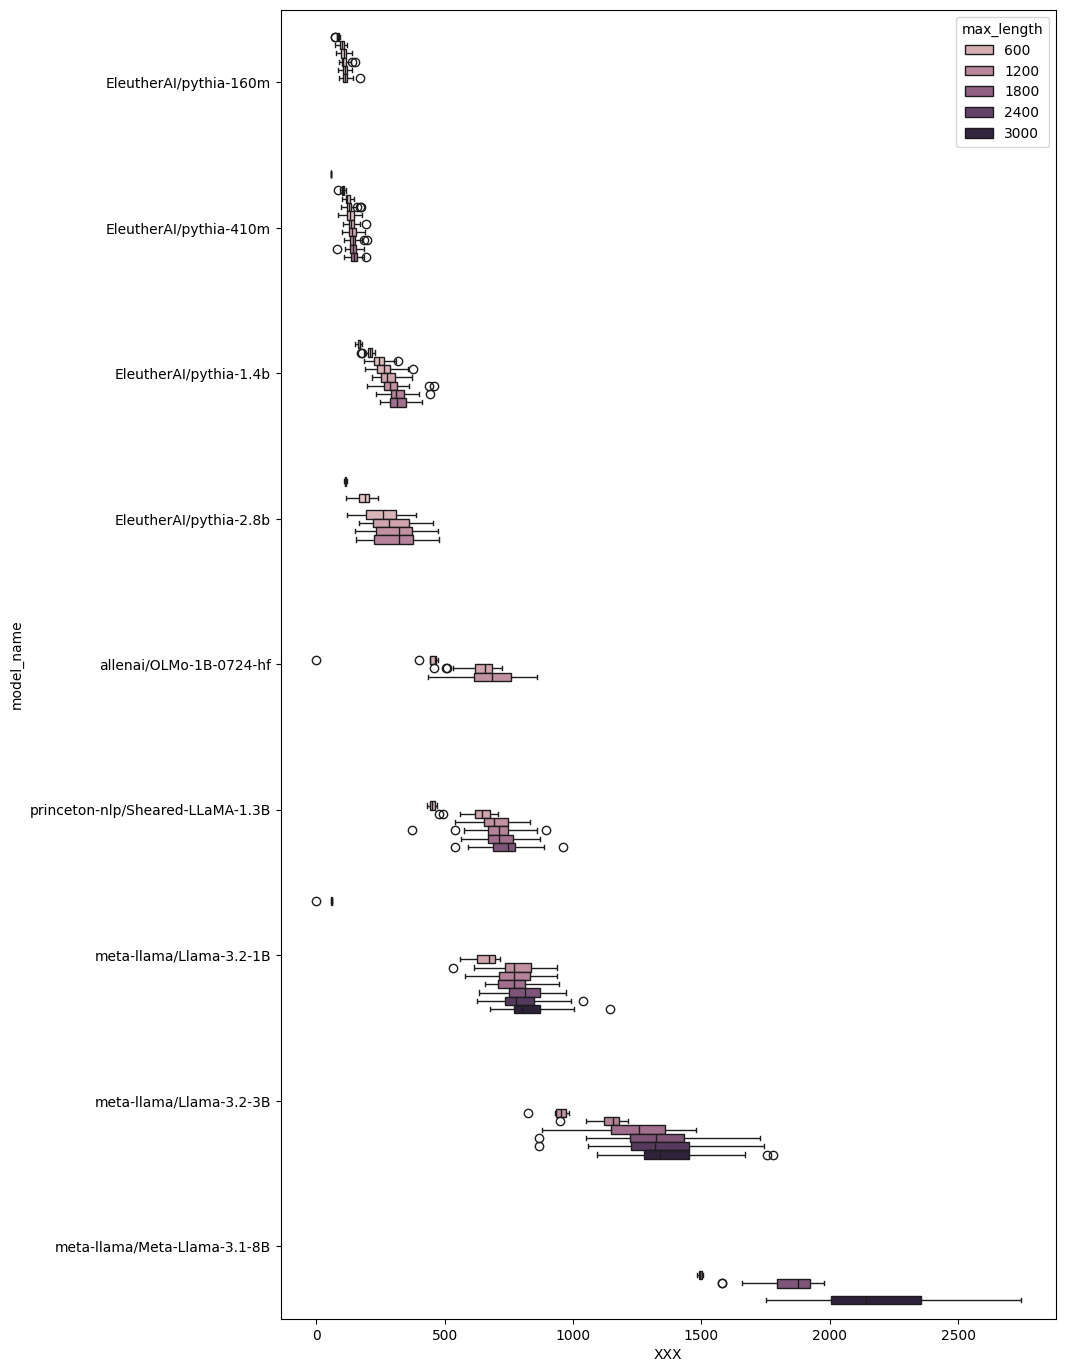

In [95]:
plt.figure(figsize=(10,17))
sns.boxplot(data=all_models_df[all_models_df['best_accuracy'] < 0.99], x='XXX', y='model_name', hue='max_length')
plt.show()

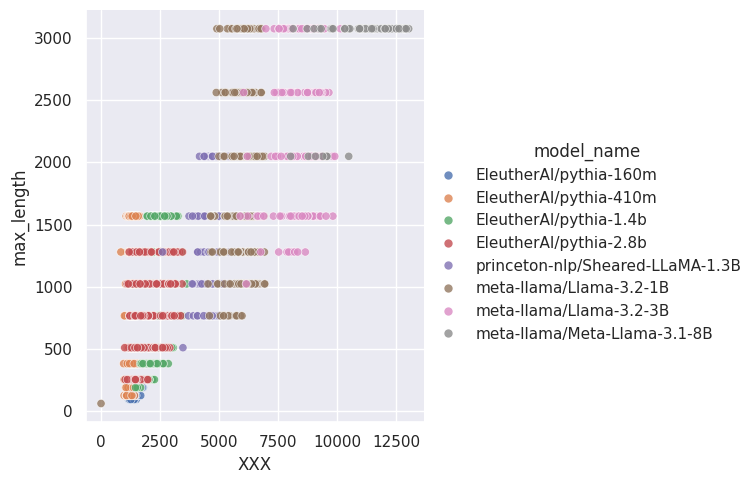

In [109]:
tmp_df = all_models_df[(all_models_df['model_name'] == 'meta-llama/Llama-3.2-3B') & (all_models_df['best_accuracy'] < 0.95)]
sns.relplot(data=all_models_df[all_models_df['best_accuracy'] < 0.95],
            x='XXX', y='max_length', hue='model_name', alpha=0.8)

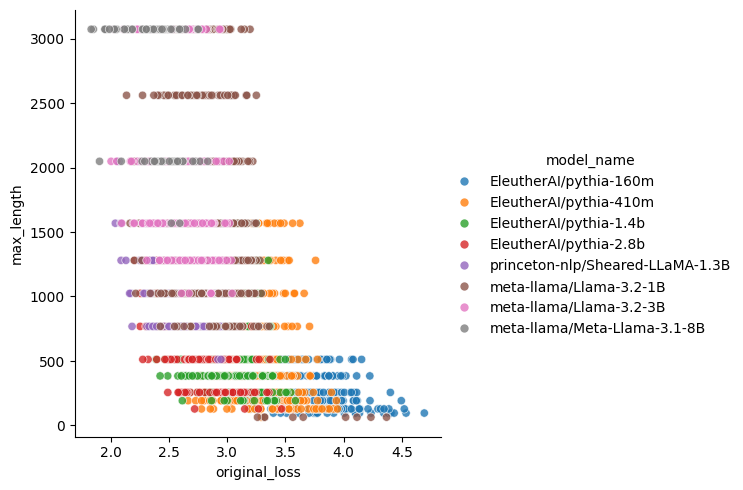

In [136]:
sns.relplot(data=all_models_df[all_models_df['best_accuracy'] < 0.99], x='original_loss', y='max_length', hue='model_name', alpha=0.8)